### The Environment has been defined so as to train a model to move the player to the top-left using Gym Environment Formulation.

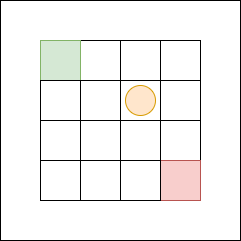

In [ ]:
!pip install stable-baselines3[extra]

In [34]:
import numpy as np
import gym 
from gym import spaces
from stable_baselines3.common.env_checker import check_env

In [54]:
#Gym environment skeleton
class Goleft_UpEnv(gym.Env):
  metadata = {'render.modes':['console']}
  LEFT = 0
  RIGHT = 1
  UP = 2 
  DOWN = 3

  def __init__(self,grid_size = 10):
    super(Goleft_UpEnv,self).__init__()

    #Size of 1d grid
    self.grid_size = grid_size 
    #Initiate at the right bottom corner 
    self.agent_pos = [grid_size - 1,0]
    n_actions = 4
    self.action_space = spaces.Discrete(n_actions)
    self.observation_space = spaces.Box(low = np.array([0,0]).astype(np.float32), high=np.array([self.grid_size,self.grid_size]).astype(np.float32),dtype=np.float32)

  def reset(self):
    #Initialize agent at right bottom corner
    self.agent_pos = [self.grid_size - 1, 0]
    return np.array([self.agent_pos[0],self.agent_pos[1]]).astype(np.float32)

  def step(self,action):
    if (action==self.LEFT):
      self.agent_pos[0] -=1
    elif (action==self.RIGHT):
      self.agent_pos[0] +=1
    elif (action==self.UP):
      self.agent_pos[1] +=1
    elif (action==self.DOWN):
      self.agent_pos[1] -=1
    else:
      raise ValueError("Received invalid action={} which is not part of the action space".format(action))
    #Account for boundaries of the grid
    self.agent_pos[0] = np.clip(self.agent_pos[0],0,self.grid_size)
    self.agent_pos[1] = np.clip(self.agent_pos[1],0,self.grid_size)

    #Target place to reach = Top left
    done = bool((self.agent_pos[0]==0)&(self.agent_pos[1]==self.grid_size-1))

    if ((self.agent_pos[0]==0) & (self.agent_pos[1]== self.grid_size-1)):
      reward = 1
    else:
      reward = 0

    info = {}

    return np.array([self.agent_pos[0],self.agent_pos[1]]).astype(np.float32), reward, done, info

  def render(self,mode='console'):
    if mode!='console':
      raise NotImplementedError()
    for i in range(self.grid_size):
      if self.grid_size - 1 - self.agent_pos[1]!=i:
        print("." * (self.grid_size))
      else:
        print("."*self.agent_pos[0], end="")
        print("x",end="")
        print("." * (self.grid_size - 1 - self.agent_pos[0]))
  
  def close(self):
    pass

In [55]:
env = Goleft_UpEnv(grid_size=4)
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

In [62]:
#Test the environment with random moves
env = Goleft_UpEnv(grid_size=4)

obs = env.reset()
env.render()

print(env.observation_space)
print(env.action_space)
print(env.action_space.sample())


# Hardcoded best agent: always go left!
n_steps = 20
for step in range(n_steps):
  print("Step {}".format(step + 1))
  move_direction = np.random.randint(4)
  obs, reward, done, info = env.step(move_direction)
  print('obs=', obs, 'reward=', reward, 'done=', done, 'move_direction = ',move_direction)
  env.render()
  if done:
    print("Goal reached!", "reward=", reward)
    break

....
....
....
...x
Box([0. 0.], [4. 4.], (2,), float32)
Discrete(4)
1
Step 1
obs= [4. 0.] reward= 0 done= False move_direction =  1
....
....
....
....x
Step 2
obs= [3. 0.] reward= 0 done= False move_direction =  0
....
....
....
...x
Step 3
obs= [2. 0.] reward= 0 done= False move_direction =  0
....
....
....
..x.
Step 4
obs= [1. 0.] reward= 0 done= False move_direction =  0
....
....
....
.x..
Step 5
obs= [2. 0.] reward= 0 done= False move_direction =  1
....
....
....
..x.
Step 6
obs= [1. 0.] reward= 0 done= False move_direction =  0
....
....
....
.x..
Step 7
obs= [1. 0.] reward= 0 done= False move_direction =  3
....
....
....
.x..
Step 8
obs= [2. 0.] reward= 0 done= False move_direction =  1
....
....
....
..x.
Step 9
obs= [2. 0.] reward= 0 done= False move_direction =  3
....
....
....
..x.
Step 10
obs= [2. 1.] reward= 0 done= False move_direction =  2
....
....
..x.
....
Step 11
obs= [2. 0.] reward= 0 done= False move_direction =  3
....
....
....
..x.
Step 12
obs= [1. 0.] rew

In [57]:
#Try baselines
from stable_baselines3 import PPO, A2C # DQN coming soon
from stable_baselines3.common.env_util import make_vec_env

# Instantiate the env
env = Goleft_UpEnv(grid_size=4)
# wrap it
env = make_vec_env(lambda: env, n_envs=1)

In [60]:
# Train the agent
model = A2C('MlpPolicy', env, verbose=1).learn(10000)

Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 20.8     |
|    ep_rew_mean        | 1        |
| time/                 |          |
|    fps                | 816      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.13    |
|    explained_variance | -2.6     |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.136   |
|    value_loss         | 0.00656  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 19.4     |
|    ep_rew_mean        | 1        |
| time/                 |          |
|    fps                | 803      |
|    iterations         | 200      |
|    time_elapsed       | 1        |
|    total_timesteps    | 1000     |
| train/             

In [63]:
# Test the trained agent
obs = env.reset()
n_steps = 20
for step in range(n_steps):
  action, _ = model.predict(obs, deterministic=True)
  print("Step {}".format(step + 1))
  print("Action: ", action)
  obs, reward, done, info = env.step(action)
  print('obs=', obs, 'reward=', reward, 'done=', done)
  env.render(mode='console')
  if done:
    # Note that the VecEnv resets automatically
    # when a done signal is encountered
    print("Goal reached!", "reward=", reward)
    break

Step 1
Action:  2
obs= [3. 1.] reward= 0 done= False
....
....
...x
....
Step 2
Action:  0
obs= [2. 1.] reward= 0 done= False
....
....
..x.
....
Step 3
Action:  0
obs= [1. 1.] reward= 0 done= False
....
....
.x..
....
Step 4
Action:  2
obs= [1. 2.] reward= 0 done= False
....
.x..
....
....
Step 5
Action:  0
obs= [0. 2.] reward= 0 done= False
....
x...
....
....
Step 6
Action:  2
obs= [0. 3.] reward= 1 done= True
x...
....
....
....
Goal reached! reward= 1


We can see that our player reached the end goal within 6 steps.